# This notebook details the analysis efforts undertaken by Sina Booeshaghi in analyzing the Biorxiv Data

### *Date: 6 May 2018*

## **Loading the Data**

In [195]:
%matplotlib inline

## Cell to import all packages
import json
import os
import operator
import pprint
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
from dateutil import parser
import pandas as pd
# use the convention variable_name

In [253]:
# Load the smallest file, change data1.txt -> data21.txt for full data
path_to_data = os.getcwd() + '/complete_data/data/data1.txt'
path_to_summary = os.getcwd() + '/complete_data/analysis/journal_summary.txt'
path_to_save = os.getcwd() + '/complete_data/analysis'


with open(path_to_data, 'rb') as f:
    papers = json.load(f)

with open(path_to_summary, 'rb') as f:
    journal_summary = json.load(f)
    
# The way to access the data is as follows:
# papers['papers'] gives you a list of all of the downloaded papers
# papers['papers'][0] gives you the first one
# papers['papers'][0][keyword] for keyword in ['abstract', 'authors', 'date', 'journal', 'link', 'text', 'title', 'twitter'] to access that info

## **Now lets look at some general information about the data we have**

In [254]:
expected_number_of_papers = 20500
number_of_papers = len(papers['papers'])
number_of_journals = len(journal_summary)
journal_summary_sorted = sorted(journal_summary.items(), key=operator.itemgetter(1), reverse=True) # Sorts by most represented journal

print "Number of papers : ", number_of_papers
print "Number of journals : ", number_of_journals
print "Top ten journals by number of papers : "
pprint.pprint(journal_summary_sorted[0:10])

Number of papers :  1025
Number of journals :  1112
Top ten journals by number of papers : 
[(u'Pre print', 11820),
 (u'Scientific Reports', 469),
 (u'eLife', 400),
 (u'PLOS ONE', 364),
 (u'DOI Not Found', 310),
 (u'Bioinformatics', 284),
 (u'Nature Communications', 224),
 (u'PNAS', 218),
 (u'PLOS Computational Biology', 208),
 (u'Genetics', 179)]


## **Here we have to now iterate through all of the data in papers to get richer information**

In [255]:
global_author_list = []
global_date_dict = {}
for paper_num in range(len(papers['papers'])):
    abstract = papers['papers'][paper_num]['abstract']
    authors  = papers['papers'][paper_num]['authors']
    date     = papers['papers'][paper_num]['date']
    journal  = papers['papers'][paper_num]['journal']
    link     = papers['papers'][paper_num]['link']
    text     = papers['papers'][paper_num]['text']
    title    = papers['papers'][paper_num]['title']
    twitter  = papers['papers'][paper_num]['twitter']
    
    # Getting a list of all of the authors
    for dude in authors:
        global_author_list.append(dude)
    
    # Getting a list of all of the dates the papers were posted
    if date not in global_date_dict:
        global_date_dict[date] = 1
    else:
        global_date_dict[date] += 1

### Author Information

In [256]:
# Getting author number counts
duplicates =  len(global_author_list)
global_author_tuple = [tuple(lst) for lst in global_author_list]
global_author_list = list(set(global_author_tuple))

# Checking out affiliations
global_aff_dict = {}

for dude in global_author_list:
    aff = dude[2]
    if aff in global_aff_dict:
        global_aff_dict[aff] += 1
    else:
        global_aff_dict[aff] = 1
        
    global_aff_list.append(aff)

# NOTE: This sorts the instutitions by the number of unique authors form that institution, 
# TODO: I definitely double counted
# TODO: The same thing but for the number of papers
# TODO: fix numbers of authors

global_aff_list = global_aff_dict.keys()
len(global_aff_dict)
global_aff_list_sorted = sorted(global_aff_dict.items(), key=operator.itemgetter(1), reverse=True) # Sorts by most represented journal

In [257]:
number_of_total_authors = len(global_author_list)
number_of_authors_pub_many = duplicates - number_of_total_authors
number_of_authors_pub_once = number_of_total_authors - number_of_authors_pub_many

number_of_publishing_institutions = len(global_aff_list)

print "Total number of authors : ", number_of_total_authors
print "Total number of authors who pub once : ", number_of_authors_pub_once
print "Total number of authors who pub many : ", number_of_authors_pub_many
print "Total number of publishing institutions : ", number_of_publishing_institutions

Total number of authors :  5043
Total number of authors who pub once :  4701
Total number of authors who pub many :  342
Total number of publishing institutions :  1804


### Date Information

In [258]:
# Working with dates
dates, number_of_papers_posted = zip(*sorted(global_date_dict.items()))
dates = list(dates)
number_of_papers_posted = list(number_of_papers_posted)

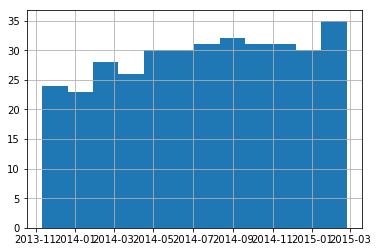

In [259]:
# Plotting number of papers posted over time
# TODO: for plotting dates need to remove the once with errors ie DOI not found
dates_dt = []
for day in dates:
    dates_dt.append(parser.parse(day))
    
dates_matplot = mdates.date2num(dates_dt)

date_series = pd.Series(dates_dt, number_of_papers_posted)
date_series.hist(bins=12)
plt.show()

## **Random Scripts that I don't really need anymore**

In [71]:
## This scripts takes the summary document and produces a dictionary with journal, num of paper pairs. it uses the old summary.txt from /complete_data/data/pdfs/
summary_dictionary = {}
for n in summary:
    new = n.split(':')
    journal = new[0:-1][0]
    ''.join(journal)
    number_of_journal_papers = new[-1].strip('\n')
    summary_dictionary[journal] = int(number_of_journal_papers)

with open(path_to_save + '/journal_summary.txt', 'w') as f:
    json.dump(summary_dictionary, f)